In [91]:
# # Add the cloned directory to Python's path to allow importing from it
# import sys
# sys.path.append('./gen-rain')

# autoreload
%load_ext autoreload
%autoreload 2

import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader

# Now import using the valid module name with an underscore
from data import GaussianRainfieldGenerator
from models import JointRainDiffuser, train
from models import time_embedding, sample

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
from models import LargeUNet, TinyUNet, SimpleVisionTransformer, LargeVisionTransformer

# number of paramaeters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# count params for LargeUnet
print(f"Number of parameters in LargeUNet: {count_parameters(TinyUNet())}")
print(f"Number of parameters in LargeUNet: {count_parameters(LargeUNet())}")
print(f"Number of parameters in SimpleVisionTransformer: {count_parameters(SimpleVisionTransformer())}")
print(f"Number of parameters in LargeVisionTransformer: {count_parameters(LargeVisionTransformer())}")


Number of parameters in LargeUNet: 46561
Number of parameters in LargeUNet: 11782337
Number of parameters in SimpleVisionTransformer: 542736
Number of parameters in LargeVisionTransformer: 33695762


In [93]:
occurrence_only = True  # Set to True if you want to use the occurrence-only model
backbone = 'large_vit'

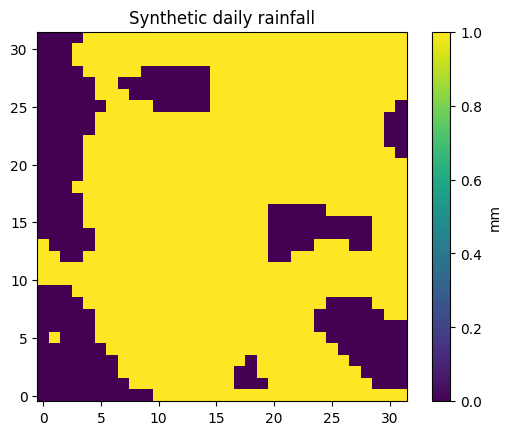

In [ ]:
# ----------------------------------------------------------------
# Example usage inside Colab
# ----------------------------------------------------------------

gen = GaussianRainfieldGenerator(
    grid_height = 32, grid_width = 32,
    length_scale = 0.1, wet_threshold = 0.4,
    amount_dist = "gamma", gamma_shape = 1.5, gamma_scale = 8.0, 
    correlated_intensity=True
)

# draw a single field to verify
field = gen.sample_precip(n_samples=1,occurrence_only=occurrence_only)[0,0]  # (H, W)

# quick visual check (works in notebooks):
import matplotlib.pyplot as plt
plt.imshow(field.cpu(), origin="lower")
plt.colorbar(label="mm")
plt.title("Synthetic daily rainfall")
plt.show()

In [95]:
# rainset = gen.make_dataset(50_000)           # 10k synthetic days
# loader  = DataLoader(rainset, batch_size=64, shuffle=True, pin_memory=True)

In [100]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

rainset = gen.make_dataset(10_000, occurrence_only=occurrence_only)  # 1000 synthetic days
loader  = DataLoader(rainset, batch_size=128, shuffle=True,
                      num_workers=0, pin_memory=True)

In [ ]:
# ---- train ---------------------------------------------
model = JointRainDiffuser(T=500, device=device, backbone=backbone)
train(model, loader, epochs=20, lr=1e-4, lam=10.0, device=device, occurrence_only=True)

Epoch 01: Lmask=0.6464
Epoch 02: Lmask=0.6442
Epoch 03: Lmask=0.6433
Epoch 04: Lmask=0.6427
Epoch 05: Lmask=0.5264
Epoch 06: Lmask=0.4867
Epoch 07: Lmask=0.4846
Epoch 08: Lmask=0.4806
Epoch 09: Lmask=0.4513


In [98]:
fields = sample(model, n=4, occurrence_only=occurrence_only)
fields_generated = gen.sample_precip(n_samples=4, occurrence_only=occurrence_only)

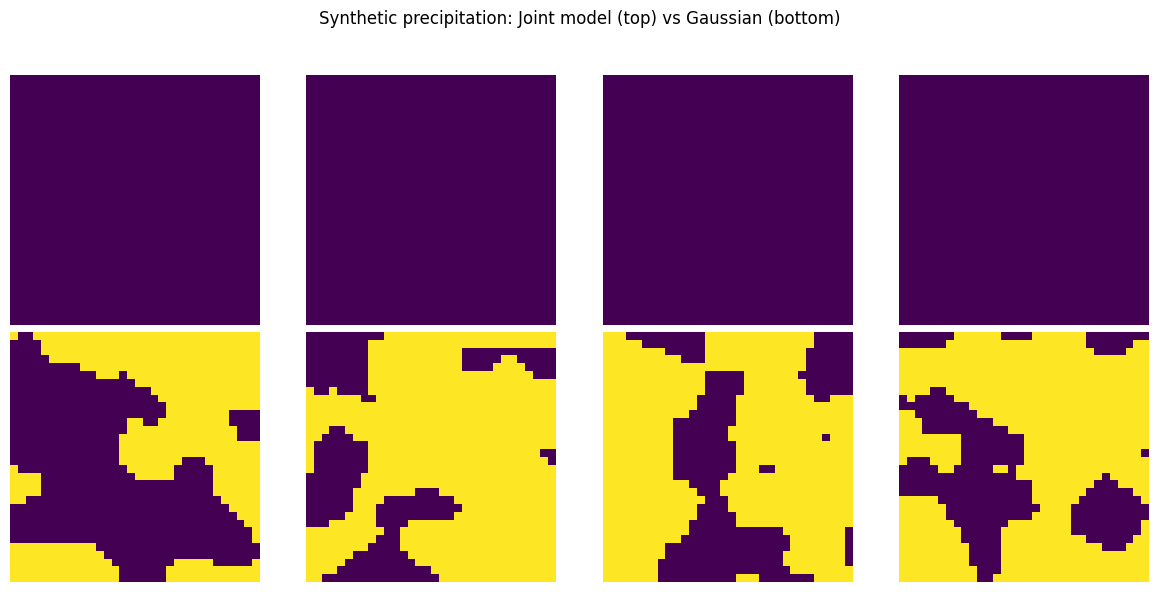

In [99]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(4):
    axes[0, i].imshow(fields[i, 0], origin='lower')
    axes[0, i].axis('off')
    axes[1, i].imshow(fields_generated[i, 0], origin='lower')
    axes[1, i].axis('off')
axes[0, 0].set_ylabel("Joint Model")
axes[1, 0].set_ylabel("Gaussian")
plt.suptitle("Synthetic precipitation: Joint model (top) vs Gaussian (bottom)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()